In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [3]:
# Read the data
ames = pd.read_csv("/Users/ben/Documents/GitHub/DSML/Data/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [13]:
# Linear Regression
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [5]:
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-1.06163284e+22, -3.48125717e+19, -2.48916748e+20, -1.45271794e+21,
       -2.57752432e+21])

In [14]:
# Ridge Regression
ridge = Ridge(alpha=1)

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

r_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", ridge)]
)

In [7]:
cross_val_score(r_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([0.8983804 , 0.91749817, 0.79251623, 0.78248152, 0.91492025])

The ridge regression has significantly better $R^2$ values than the linear regression. The plot of the coefficients for the two regressions is below. The ridge coefficients are much smaller and many are located very close to or equal to zero.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

lr_fitted_pipeline = lr_pipeline_1.fit(X_train, y_train)
r_fitted_pipeline = r_pipeline_1.fit(X_train, y_train)

lr_coef = lr_fitted_pipeline.named_steps["linear_regression"].coef_
r_coef = r_fitted_pipeline.named_steps["ridge_regression"].coef_

coefs = pd.DataFrame({"Linear Regression": lr_coef, "Ridge Regression": r_coef})

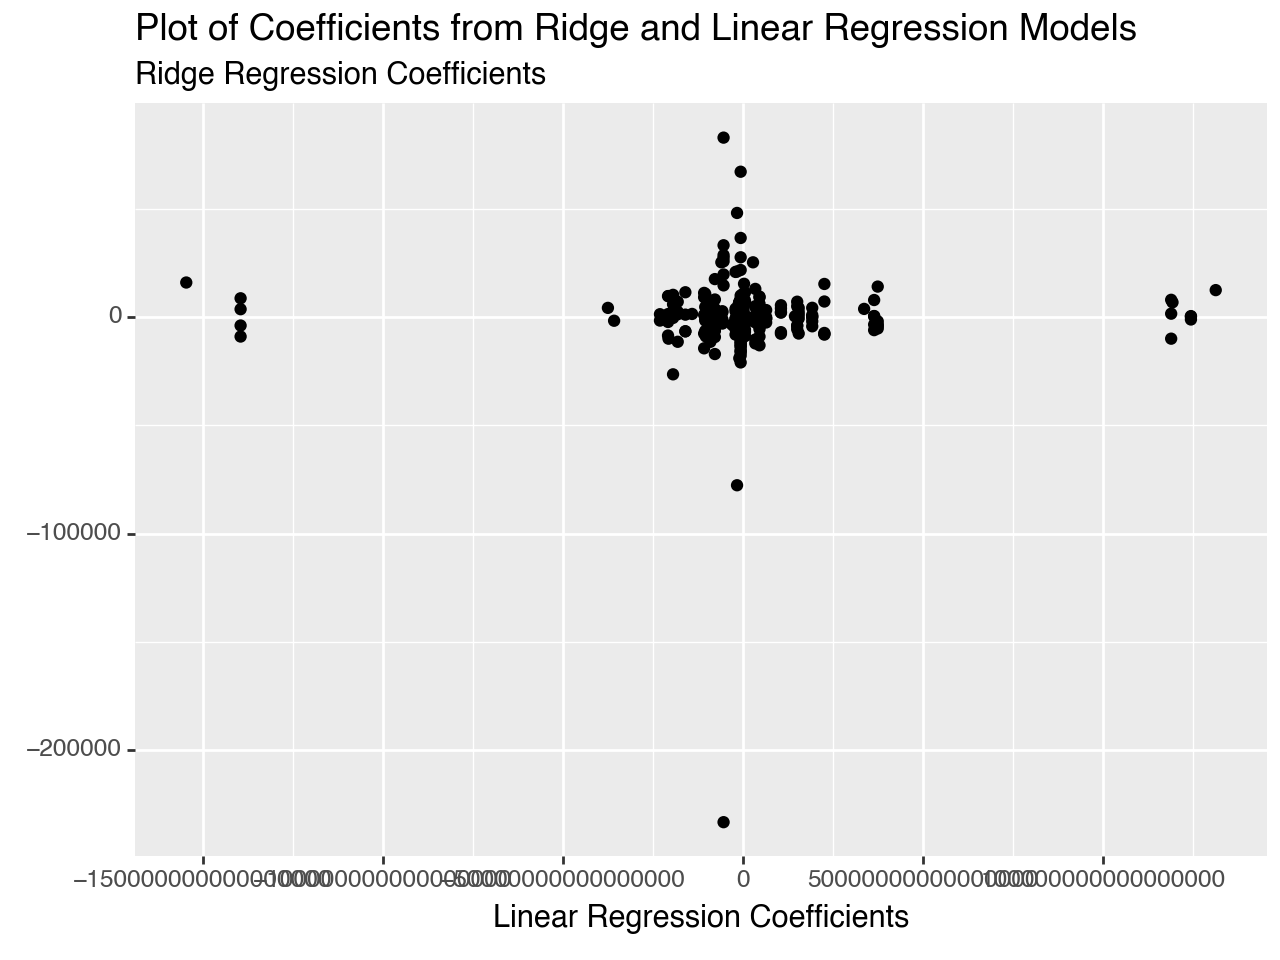

<Figure Size: (640 x 480)>

In [18]:
from plotnine import ggplot, aes, labs, geom_point
(ggplot(coefs, aes(x = "Linear Regression", y = "Ridge Regression")) +
    geom_point() +
    labs(
        x = "Linear Regression Coefficients",
        y = "",
        subtitle = "Ridge Regression Coefficients",
        title = "Plot of Coefficients from Ridge and Linear Regression Models"
    ))

In [19]:
alphas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10]}

ridge = Ridge()

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

r_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", ridge)]
)

In [20]:
gscv = GridSearchCV(r_pipeline_1, alphas, cv = 5, scoring='r2')
gscv_fitted = gscv.fit(X, y)

In [21]:
gscv_fitted.cv_results_["mean_test_score"]

array([0.85294546, 0.85322362, 0.85542319, 0.86115931, 0.86335485])

In [22]:
alphas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10]}

lasso = Lasso()

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", lasso)]
)

In [23]:
gscv = GridSearchCV(lasso_pipeline_1, alphas, cv = 5, scoring='r2')
gscv_fitted = gscv.fit(X, y)

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+11, tolerance: 1.348e+09
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+11, tolerance: 1.474e+09
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+11, tolerance: 1.463e+09
/Users/ben/anaconda3/lib/python3.11/site-packages/sk

In [24]:
gscv_fitted.cv_results_["mean_test_score"]

array([0.8544398 , 0.85454916, 0.85539429, 0.85589007, 0.85949508])

In [45]:
lasso = Lasso(alpha = 10)

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", lasso)]
)

lasso_fitted_pipeline = lasso_pipeline_1.fit(X_train, y_train)

lasso_coef = lasso_fitted_pipeline.named_steps["lasso_regression"].coef_

array([-1.10252748e+04,  1.51738447e+03, -0.00000000e+00,  5.54184491e+03,
        1.37071316e+03, -2.63894821e+03, -1.32752225e+04,  3.40765784e-10,
       -7.59026172e+02,  3.73549324e+03, -2.71539363e+03,  1.86498406e+02,
       -1.13759487e+04,  1.00196196e+04, -5.89718478e+03,  5.24086673e+00,
        1.61921196e+03, -2.58418679e-10, -0.00000000e+00,  7.76765125e+03,
       -4.44027205e+03, -5.85383136e+03,  1.18028746e+03, -0.00000000e+00,
        2.61935868e+03, -1.64660080e+04,  8.25530948e+03,  6.16452170e+03,
        1.05841959e+04,  3.49934922e+03, -0.00000000e+00, -2.75934561e+03,
        1.41026113e+04, -1.38660413e+04, -7.40038828e+03,  4.55337189e+03,
        1.21071574e+05, -4.35337927e+03,  0.00000000e+00,  2.11563116e+03,
       -6.57266916e+03, -7.41999870e+03,  1.06595127e+04, -1.29124392e+04,
        3.02926224e+04,  2.87064838e+04, -7.64039751e+03, -6.33854704e+03,
       -4.92704363e+03, -5.72215505e+03,  1.20503604e+04,  4.34338899e+04,
       -2.30008124e+03, -

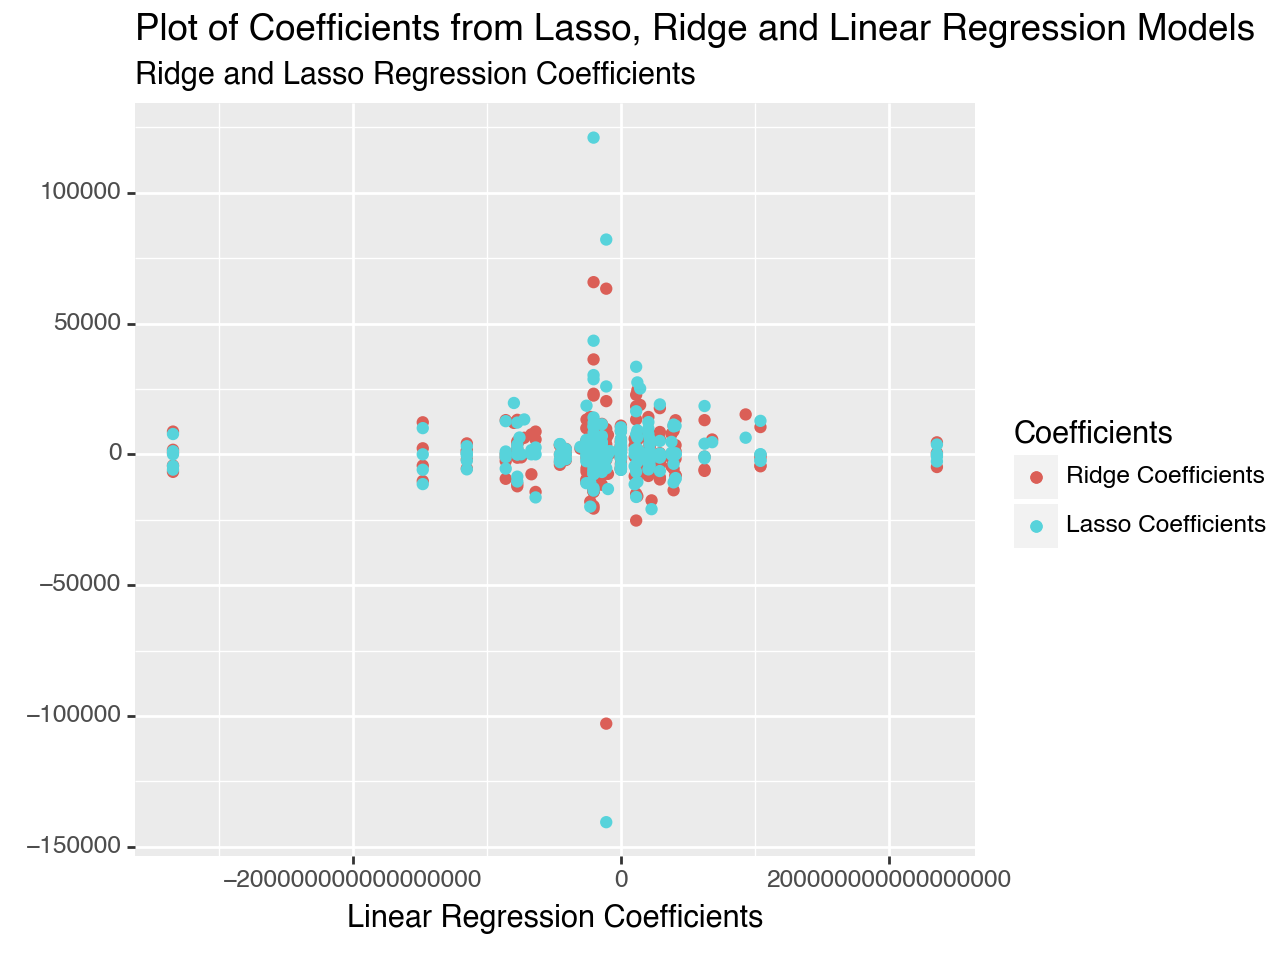

<Figure Size: (640 x 480)>

In [60]:
coefs["Lasso Regression"] = lasso_coef
(ggplot(coefs, aes(x = "Linear Regression")) +
    geom_point(aes(y = "Ridge Regression", color = '"Ridge Coefficients"')) +
    geom_point(aes(y = "Lasso Regression", color = '"Lasso Coefficients"')) +
    labs(
        x = "Linear Regression Coefficients",
        y = "",
        subtitle = "Ridge and Lasso Regression Coefficients",
        title = "Plot of Coefficients from Lasso, Ridge and Linear Regression Models",
        color = "Coefficients"
    ))

The lasso coefficients fall on average closer to zero than the lasso coefficients, excluding a few points.

In [61]:
alphas = {"elastic_net__alpha": [.001, .01, .1, 1, 10], "elastic_net__l1_ratio": [.001, .01, .1, 1]}

en = ElasticNet()

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

elastic_net_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", en)]
)

In [62]:
gscv = GridSearchCV(elastic_net_pipeline_1, alphas, cv = 5, scoring='r2')
gscv_fitted = gscv.fit(X, y)

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e+11, tolerance: 1.348e+09
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.277e+11, tolerance: 1.474e+09
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.083e+11, tolerance: 1.463e+09
/Users/ben/anaconda3/lib/python3.11/site-packages/sk

In [66]:
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15f44e690>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15d331890>)])),
                ('elastic_net', ElasticNet(alpha=0.01, l1_ratio=0.1))])

In [68]:
en = ElasticNet(alpha=.01, l1_ratio=.1)

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

elastic_net_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", en)]
)

In [69]:
elastic_net_fitted_pipeline = elastic_net_pipeline_1.fit(X_train, y_train)

elastic_net_coefs = elastic_net_fitted_pipeline.named_steps["elastic_net"].coef_

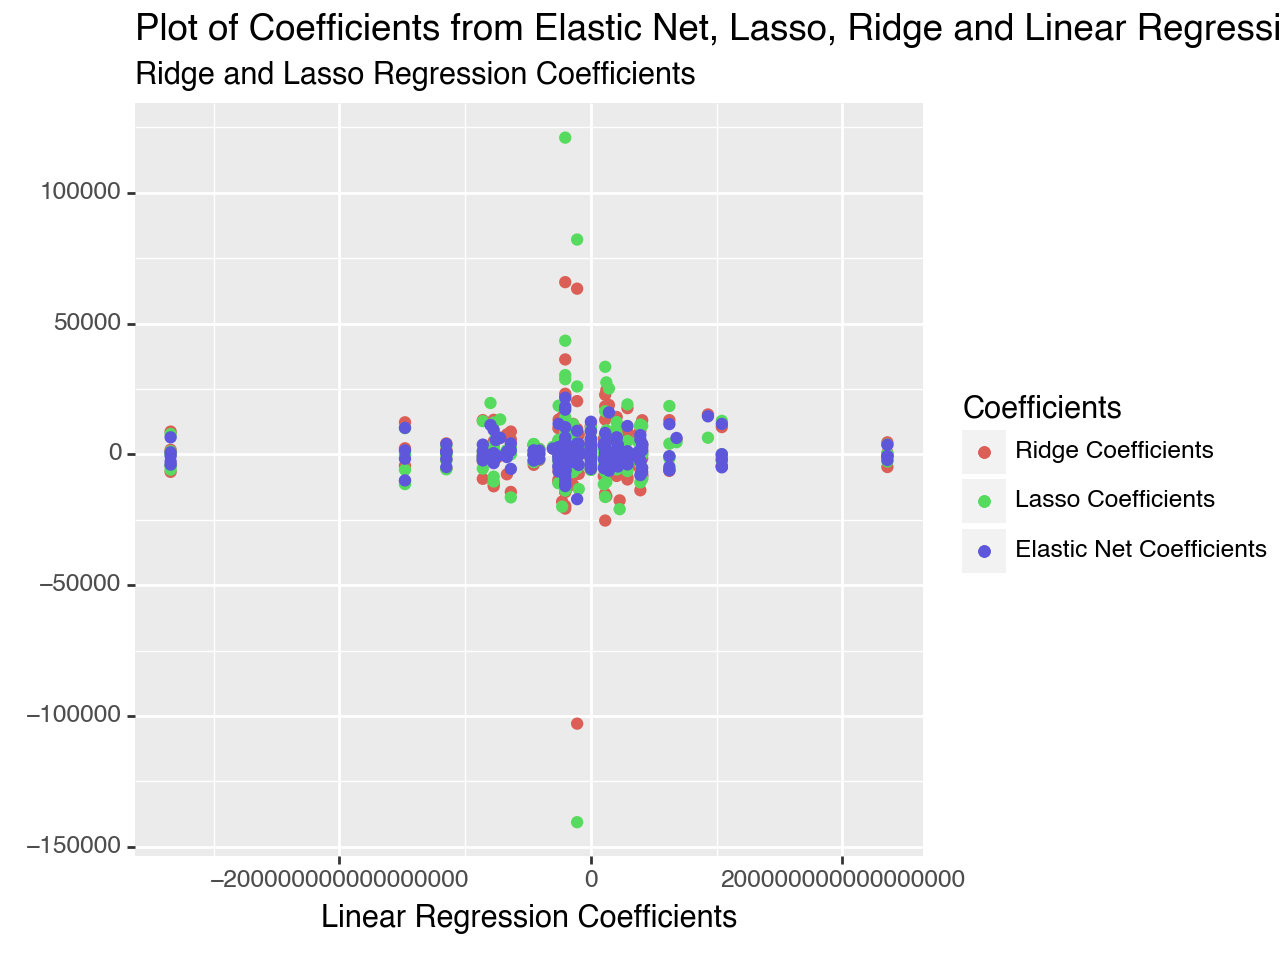

<Figure Size: (640 x 480)>

In [70]:
coefs["Elastic Net Regression"] = elastic_net_coefs
(ggplot(coefs, aes(x = "Linear Regression")) +
    geom_point(aes(y = "Ridge Regression", color = '"Ridge Coefficients"')) +
    geom_point(aes(y = "Lasso Regression", color = '"Lasso Coefficients"')) +
    geom_point(aes(y = "Elastic Net Regression", color = '"Elastic Net Coefficients"')) +
    labs(
        x = "Linear Regression Coefficients",
        y = "",
        subtitle = "Ridge and Lasso Regression Coefficients",
        title = "Plot of Coefficients from Elastic Net, Lasso, Ridge and Linear Regression Models",
        color = "Coefficients"
    ))

The coefficients from the elastic net regression appear to be better than both lasso and ridge regression, and significantly better than the linear regression.